In [191]:
import numpy as np 
import pandas as pd # data 
import seaborn; seaborn.set()
from sklearn.metrics import mean_squared_error

In [192]:
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [193]:
data = pd.read_csv("Data.csv", index_col ='Date')
print(data.head(5))
print(data.tail(5))
data.dtypes
data.info()
data.describe()

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-05-24  9212.283203  9288.404297  8787.250977  8790.368164  8790.368164   
2020-05-25  8786.107422  8951.005859  8719.667969  8906.934570  8906.934570   
2020-05-26  8909.585938  8991.967773  8757.293945  8835.052734  8835.052734   
2020-05-27  8837.380859  9203.320313  8834.157227  9181.017578  9181.017578   
2020-05-28  9184.945313  9546.319336  9148.457031  9525.750977  9525.750977   

                  Volume  
Date                      
2020-05-24  3.251880e+10  
2020-05-25  3.128816e+10  
2020-05-26  2.958419e+10  
2020-05-27  3.274054e+10  
2020-05-28  3.436707e+10  
                    Open          High           Low         Close  \
Date                                                                 
2021-05-20  36753.667969  42462.984375  35050.617188  40782.738281   
2021-05-21  40596.949219  42172.171875  33616.4

,Open,High,Low,Close,Adj Close,Volume
count,363.000000,363.000000,363.000000,363.000000,363.000000,3.630000e+02
mean,26996.045414,27792.823657,26096.903199,27059.156923,27059.156923,4.331712e+10
std,18731.918763,19333.245603,17979.886665,18710.572817,18710.572817,2.748881e+10
min,8786.107422,8951.005859,8719.667969,8790.368164,8790.368164,1.225260e+10
25%,10778.326172,10939.215821,10644.950683,10792.284668,10792.284668,2.368586e+10
50%,18051.320313,18553.298828,17619.533203,18177.484375,18177.484375,3.699287e+10
75%,46593.199219,48417.126953,45141.027344,46620.646485,46620.646485,5.826126e+10
max,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11


In [194]:
data['Price'].plot()
plt.ylabel('Daily Bitcoin price ')

KeyError: 'Price'

In [ ]:
# Converting the data to a logarithmic scale
data_log = pd.DataFrame(np.log(data['Price']))

In [ ]:
# Differencing the log values
log_diff = data_log.diff().dropna()

In [ ]:
# Using the Dickey-Fuller test to check for stationarity
results = adfuller(log_diff['Price'])
print(f"P-value: ", results)

P-value:  (-13.60880761409225, 1.8905663051450028e-25, 3, 869, {'1%': -3.437897435722137, '5%': -2.8648716746706326, '10%': -2.568544030438542}, -3030.068599254774)


Text(0.5, 0, 'Diffencing Log ')

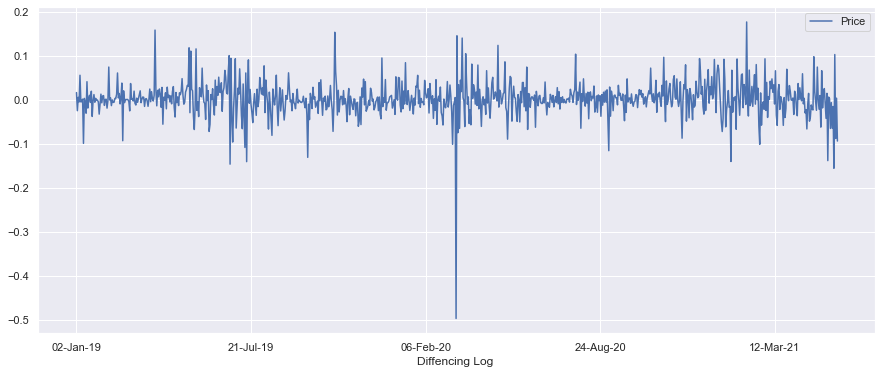

In [ ]:
log_diff.plot()
plt.xlabel('Diffencing Log ')

In [ ]:
#ACF and PACF plots:
lag_acf = acf(log_diff, nlags=30, fft = False)


In [ ]:
lag_pacf = pacf(log_diff, nlags=50, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

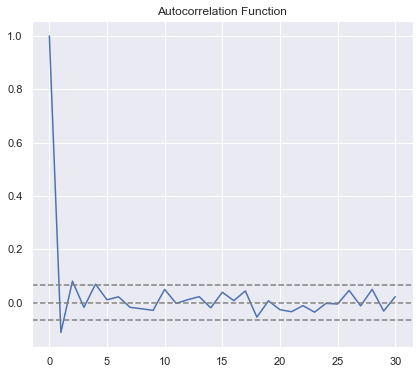

In [ ]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

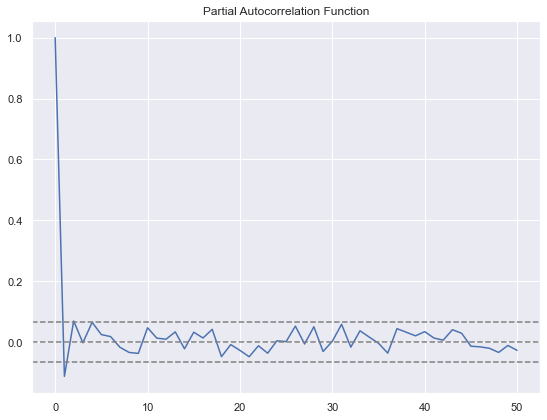

In [ ]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
def best_param(model, data, pdq, pdqs):
    """
    Loops through each possible combo for pdq and pdqs
    Runs the model for each combo
    Retrieves the model with lowest AIC score
    """
    ans = []
    for comb in tqdm(pdq):
        for combs in tqdm(pdqs):
            try:
                mod = model(data,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                            freq='D')

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df.aic.idxmin()]

In [ ]:
# Splitting 80/20
index = round(len(data)*.80)
train = data_log.iloc[:index]
test = data_log.iloc[index:]

In [ ]:
# Fitting the model to the training set
model = SARIMAX(train, 
                order=(1, 0, 0), 
                seasonal_order=(0,0,0,0), 
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [ ]:
steps = len(data) - index
forecast=output.get_forecast(steps=steps)

In [ ]:
#predictions and confidence intervals
predictions = forecast.predicted_mean
ci = forecast.conf_int()


In [ ]:
pred = predictions.to_frame().rename(columns={'predicted_mean':'Price'})
pred.index = pred.index.astype(str)

all_ = train.append(pred)
print(all_)

                Price
01-Jan-19    8.245227
02-Jan-19    8.261991
03-Jan-19    8.237506
04-Jan-19    8.243467
05-Jan-19    8.238907
...               ...
2021-05-19  10.218679
2021-05-20  10.221128
2021-05-21  10.223578
2021-05-22  10.226028
2021-05-23  10.228479

[874 rows x 1 columns]


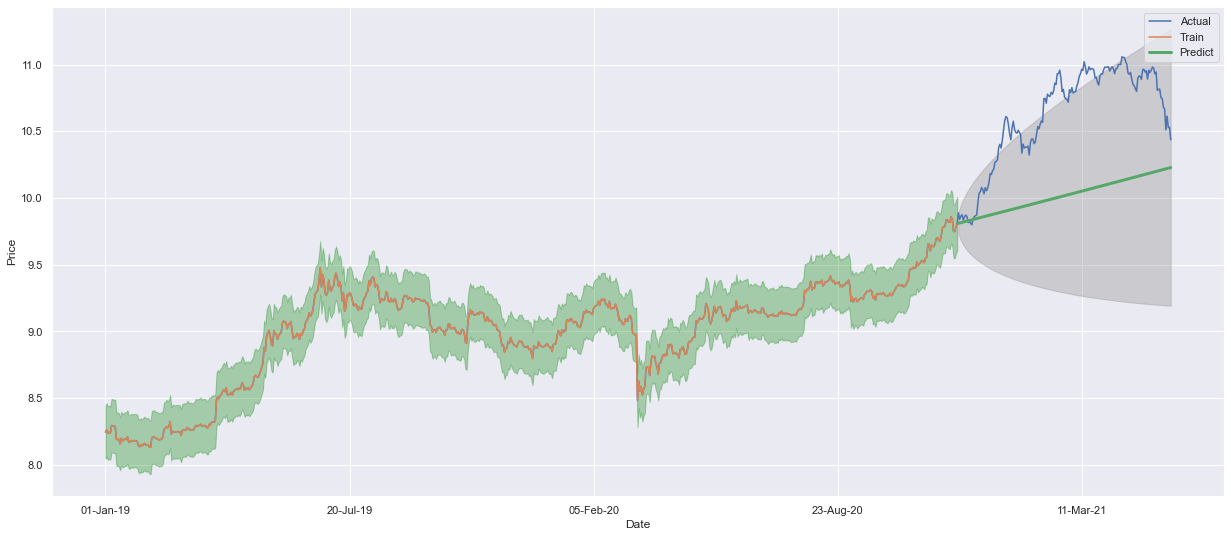

In [ ]:
#observes plots
fig = data_log['Price'].plot(label = 'Actual',  figsize = (21,9))

fig.plot(train['Price'], label = 'Train')

fig.plot(pred['Price'], label = 'Predict' ,linewidth=3)


fillup = train['Price'] - 0.2
filldo = train['Price'] + 0.2
# fig.plot(filll, label = 'Actual')
fig.fill_between(train.index, fillup, filldo, color='green', alpha=0.3)
fig.fill_between(pred.index, ci['lower Price'].values, ci['upper Price'].values, color='gray', alpha=0.3)

fig.set_xlabel('Date')
fig.set_ylabel('Price')
fig.legend()
# fig.fill_between(ci.index,  
#                 ci.iloc[:, 0],
#                 ci.iloc[:, 1], color ='k', alpha=.2)



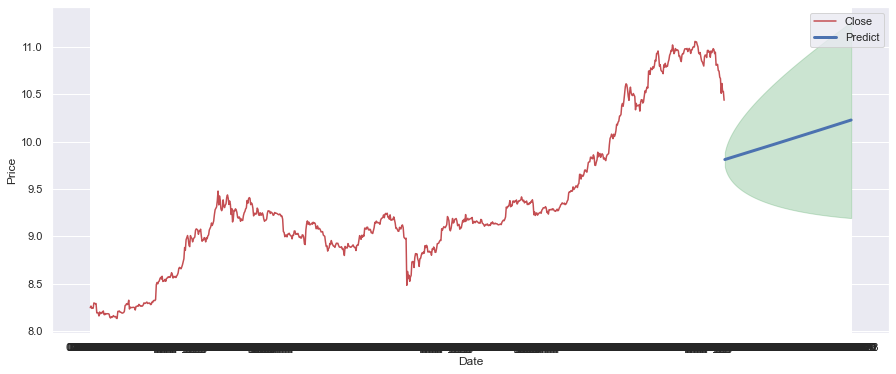

In [ ]:
#observes plots
fig, ax = plt.subplots()
ax.plot(data_log['Price'], label = 'Close', color ='r')

# fig.plot(train['Price'], label = 'Close')

ax.plot(pred['Price'], label = 'Predict' ,linewidth=3)


# fillup = train['Price'] - 0.2
# filldo = train['Price'] + 0.2
# fig.plot(filll, label = 'Actual')
# fig.fill_between(train.index, fillup, filldo, color='green', alpha=0.3)
ax.fill_between(pred.index, ci['lower Price'].values, ci['upper Price'].values, color='g', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
# fig.fill_between(ci.index,  
#                 ci.iloc[:, 0],
#                 ci.iloc[:, 1], color ='k', alpha=.2)

